In [193]:
"""
Created on Sun Feb 14 21:01:54 2016

@author: Walter Martins-Filho
e-mail: walter at on.br
        waltersmartinsf at gmail.com
"""
#******************************************************************************
#Main Goal: include the time_info in the header of the images.
#******************************************************************************

print '\n Including time information in the header \n'
print '\n Loading packages .... \n'

from pyraf import iraf #IRAF
from login import * #IRAF configurations
from astropy.io import fits #import and export fits images
import glob #package for list files
import os #package for control bash commands
import useful_functions as use #useful functions
import yaml #input data without any trouble
from string import split #use to unconcanated a string in parts
from pandas import DataFrame, read_csv #work with dataframes
from photutils import CircularAperture, aperture_photometry,CircularAnnulus,Background #Photometry routines 
from astropy.table import hstack
import numpy as np
from scipy import array
print '\n.... Done.'


 Including time information in the header 


 Loading packages .... 


.... Done.


In [231]:
%matplotlib inline
import pylab

import matplotlib.pyplot as plt #plot library
def init_plotting():
    """
    Funcao para definir uma janela grafica com parametros customizados para aptresentacoes em ppt ou latex.
    """
    plt.rcParams['figure.figsize'] = (14.0,8.0)
    plt.rcParams['font.size'] = 20
    #plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['axes.labelsize'] = plt.rcParams['font.size']
    plt.rcParams['axes.titlesize'] = 0.75*plt.rcParams['font.size']
    plt.rcParams['legend.fontsize'] = 0.65*plt.rcParams['font.size']
    plt.rcParams['xtick.labelsize'] = plt.rcParams['font.size']
    plt.rcParams['ytick.labelsize'] = plt.rcParams['font.size']
    plt.rcParams['xtick.major.size'] = 3
    plt.rcParams['xtick.minor.size'] = 3
    plt.rcParams['xtick.major.width'] = 1
    plt.rcParams['xtick.minor.width'] = 1
    plt.rcParams['ytick.major.size'] = 3
    plt.rcParams['ytick.minor.size'] = 3
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['ytick.minor.width'] = 1
    plt.rcParams['legend.frameon'] = True
    plt.rcParams['legend.loc'] = 'best'
    plt.rcParams['axes.linewidth'] = 1

init_plotting()

In [204]:
cd /home/walter/github/iraf_task/

/home/walter/github/iraf_task


In [205]:
ls

calibration_time.py         license                       pyraf/
development/                login.cl                      README.md
ExoSetupTaskParameters.py   login.py                      run.sh
ExoSetupTaskParameters.pyc  login.pyc                     science.py
imstatistics.py             masterbias.py                 time_info.py
input_05jan12.yaml          masterflat.py                 useful_functions.py
INPUT_PARAMETERS            Photometry Development.ipynb  useful_functions.pyc
legalcode                   photometry.py


In [206]:
#input data
print '\nReading input*.yaml file ....\n'
#******************************************************************************
#**************** BEGIN INPUT PATH FILE ***************************************
#******************************************************************************
#path for your data directory, path for your data save, and names for the lists
#Import with yaml file: input path and prefix information for files
input_file = glob.glob('input*.yaml')
if input_file:
    if len(input_file) == 1:
        print 'reading input file ... \n'
        file = yaml.load(open(input_file[0])) #creating our dictionary of input variables
        data_path = file['data_path']
        save_path = file['save_path']
        planet = file['exoplanet']
        print '....  done! \n'
    if len(input_file) > 1:
        print 'reading input file ... \n'
        print '.... there is more than 1 input_path*.yaml.\n \nPlease, remove the others files that you do not need. \n'
        raise SystemExit
else:
    print 'There is no input_path*.yaml. \nPlease, create a input file describe in INPUT_PARAMETERS.'
    raise SystemExit
#******************************************************************************
#******************* END INPUT PATH FILE **************************************
#******************************************************************************


print 'YAML information:'
input_file = file
print input_file


Reading input*.yaml file ....

reading input file ... 

....  done! 

YAML information:
{'u.DEC': 'degree', 'frame': 'fk5', 'data_path': '/home/walter/exoplanet/data/xo2b/xo2b.b', 'time_zone': 7.0, 'pxpositions': [582.79, 581.76, 559.06, 512.4], 'circular_orbit': False, 'skysection': [526, 81], 'lon-obs': -110.734527778, 'DEC': '+50:13:32.9', 'observatory': 'mtbigelow', 'u.RA': 'degree', 'altitude': 2510.0, 'lat-obs': 32.4164722222, 'exoplanet': 'xo2b', 'date-obs': 'DATE-OBS', 'epoch': '2000.0', 'RA': '07:48:06.46', 'save_path': '/home/walter/exoplanet/data/xo2b/xo2b.b/iraf_task', 'time': 'ut', 'time-obs': 'UT', 'scale-time': 'utc'}


In [105]:
input_file

{'DEC': '+50:13:32.9',
 'RA': '07:48:06.46',
 'altitude': 2510.0,
 'circular_orbit': False,
 'data_path': '/home/walter/exoplanet/data/xo2b/xo2b.b',
 'date-obs': 'DATE-OBS',
 'epoch': '2000.0',
 'exoplanet': 'xo2b',
 'frame': 'fk5',
 'lat-obs': 32.4164722222,
 'lon-obs': -110.734527778,
 'observatory': 'mtbigelow',
 'pxpositions': [582.79, 581.76, 559.06, 512.4],
 'save_path': '/home/walter/exoplanet/data/xo2b/xo2b.b/iraf_task',
 'scale-time': 'utc',
 'skysection': '526:625,81:180',
 'time': 'ut',
 'time-obs': 'UT',
 'time_zone': 7.0,
 'u.DEC': 'degree',
 'u.RA': 'degree'}

In [106]:
input_file['pxpositions']

[582.79, 581.76, 559.06, 512.4]

# Using photutils 

http://photutils.readthedocs.io/en/latest/photutils/aperture.html

In [107]:
N_obj = len(input_file['pxpositions'])/2.

print 'Number of objects = ',N_obj

positions = []
for i in range(len(input_file['pxpositions'])):
    if i % 2 == 0: #if the number is a even (or not a odd), the turple is created
        positions.append((input_file['pxpositions'][i],input_file['pxpositions'][i+1]))

Number of objects =  2.0


In [108]:
positions

[(582.79, 581.76), (559.06, 512.4)]

In [109]:
apertures = CircularAperture(positions, r=7.) #create apertures with 3pixel radius center in the positions

In [110]:
#change to save data reduction directory
os.chdir(save_path)

In [111]:
print '\n Reading the list of images ....\n'
images = sorted(glob.glob('AB'+planet+'*.fits'))
print images


 Reading the list of images ....

['ABxo2b.0002.fits', 'ABxo2b.0004.fits', 'ABxo2b.0006.fits', 'ABxo2b.0008.fits', 'ABxo2b.0010.fits', 'ABxo2b.0012.fits', 'ABxo2b.0014.fits', 'ABxo2b.0016.fits', 'ABxo2b.0018.fits', 'ABxo2b.0020.fits', 'ABxo2b.0022.fits', 'ABxo2b.0024.fits', 'ABxo2b.0026.fits', 'ABxo2b.0028.fits', 'ABxo2b.0030.fits', 'ABxo2b.0032.fits', 'ABxo2b.0034.fits', 'ABxo2b.0036.fits', 'ABxo2b.0038.fits', 'ABxo2b.0040.fits', 'ABxo2b.0042.fits', 'ABxo2b.0044.fits', 'ABxo2b.0046.fits', 'ABxo2b.0048.fits', 'ABxo2b.0050.fits', 'ABxo2b.0052.fits', 'ABxo2b.0054.fits', 'ABxo2b.0056.fits', 'ABxo2b.0058.fits', 'ABxo2b.0060.fits', 'ABxo2b.0062.fits', 'ABxo2b.0064.fits', 'ABxo2b.0066.fits', 'ABxo2b.0068.fits', 'ABxo2b.0070.fits', 'ABxo2b.0072.fits', 'ABxo2b.0074.fits', 'ABxo2b.0076.fits', 'ABxo2b.0078.fits', 'ABxo2b.0080.fits', 'ABxo2b.0082.fits', 'ABxo2b.0084.fits', 'ABxo2b.0086.fits', 'ABxo2b.0088.fits', 'ABxo2b.0090.fits', 'ABxo2b.0092.fits', 'ABxo2b.0094.fits', 'ABxo2b.0096.fits', 'ABx

In [112]:
#Now, We will import the fits file as a matrix:

for i in range(len(images)):
    hdr = fits.getheader(images[i])
    #use.update_progress(i/(len(images)))

In [113]:
im,hdr = fits.getdata(images[0],header=True)

In [114]:
im = np.array(im,dtype='Float64') #transform data to a matrix float 64

In [115]:
np.shape(im) #shape of the image

(1365, 1365)

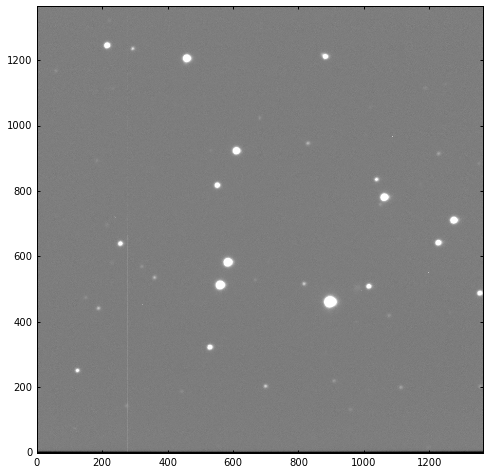

In [116]:
pylab.figure()
pylab.imshow(im,origin='lower', cmap=pylab.cm.gray,vmin=np.mean(im)-np.std(im),vmax=np.mean(im)+np.std(im))

In [117]:
#Return to photometry procedure....

phot_table = aperture_photometry(im, apertures)

In [118]:
print(phot_table)

 aperture_sum xcenter ycenter
                pix     pix  
------------- ------- -------
488915.994443  582.79  581.76
528168.981992  559.06   512.4


In [119]:
print phot_table[0][0]
print phot_table[1][0]

488915.994443
528168.981992


In [120]:
flux = []

for i in range(int(N_obj)):
    flux.append(phot_table[i][0])

In [121]:
flux

[488915.9944431191, 528168.98199162353]

In [122]:
flux_data = []
for i in images:
    im,hdr = fits.getdata(i,header=True)
    im = np.array(im,dtype='Float64')
    phot_table = aperture_photometry(im, apertures)
    flux = []
    for j in range(int(N_obj)):
        flux.append(phot_table[j][0])
    flux_data.append(flux)

In [123]:
flux_data = DataFrame(flux_data,columns=['hoststar','refstar'])

In [124]:
flux_data

,hoststar,refstar
0,488915.994443,528168.981992
1,555346.701098,600259.468358
2,575050.051338,621355.407900
3,504921.483618,543370.476716
4,490978.315974,530144.701772
5,585485.043480,634924.536775
6,609263.744071,657937.124256
7,594162.740517,640712.692218
8,586931.710568,634412.363575
9,641159.396422,690473.304964


In [125]:
time_hjd = read_csv('./results_iraf_calibrations.csv')

In [126]:
time_hjd.HJD.values

array([ 2456271.73341415,  2456271.73500033,  2456271.73658732,
        2456271.73817571,  2456271.73976281,  2456271.74134749,
        2456271.74293367,  2456271.74452333,  2456271.74611159,
        2456271.74770067,  2456271.74928778,  2456271.75087894,
        2456271.75246512,  2456271.75405489,  2456271.75564096,
        2456271.75722922,  2456271.75881575,  2456271.76040089,
        2456271.76198719,  2456271.76357476,  2456271.7651643 ,
        2456271.76675048,  2456271.76834026,  2456271.76992679,
        2456271.77151204,  2456271.77309927,  2456271.77468441,
        2456271.7762729 ,  2456271.7778592 ,  2456271.77944909,
        2456271.7810377 ,  2456271.78262388,  2456271.78420995,
        2456271.78579648,  2456271.78738359,  2456271.78896966,
        2456271.79055908,  2456271.79214538,  2456271.79373364,
        2456271.7953211 ,  2456271.7969074 ,  2456271.79849392,
        2456271.80008126,  2456271.80166733,  2456271.80325305,
        2456271.80484317,  2456271.80642

In [127]:
len(time_hjd.HJD.values)

133

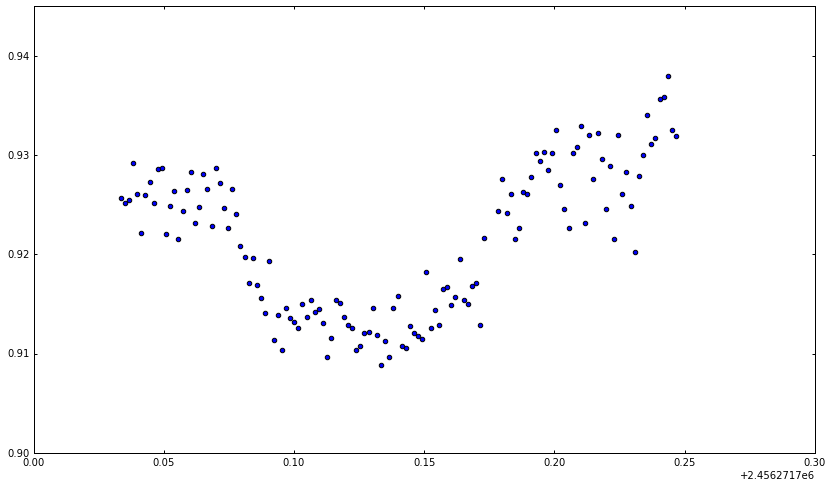

In [128]:
plt.figure()
plt.scatter(time_hjd.HJD,flux_data.hoststar/flux_data.refstar)

# Background

In [212]:
bkg = Background(im,tuple(input_file['skysection'])) #estimating the background using a boxpixel 

In [213]:
bkg.background

array([[ 13.95456783,  13.95455579,  13.95452001, ...,  14.37761965,
         14.37812636,  14.37859916],
       [ 13.95456849,  13.95455645,  13.95452067, ...,  14.37761991,
         14.37812662,  14.37859942],
       [ 13.95457047,  13.95455843,  13.95452265, ...,  14.37762071,
         14.37812741,  14.37860021],
       ..., 
       [ 14.17306772,  14.17306508,  14.1730573 , ...,  14.56385057,
         14.56434806,  14.56481247],
       [ 14.17303756,  14.17303492,  14.17302711, ...,  14.56392805,
         14.56442612,  14.56489108],
       [ 14.1730074 ,  14.17300475,  14.17299692, ...,  14.56400523,
         14.56450386,  14.56496936]])

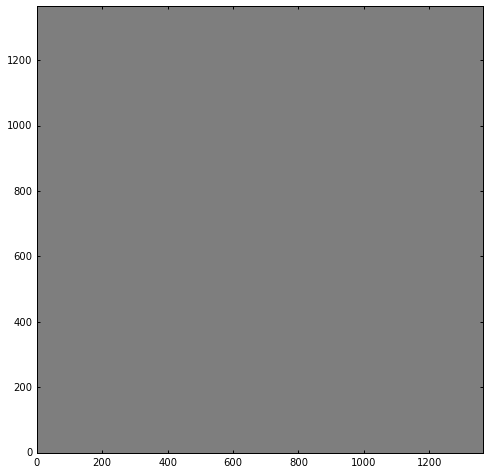

In [214]:
pylab.figure()
pylab.imshow(bkg.background,origin='lower', cmap=pylab.cm.gray,vmin=np.mean(im)-np.std(im),vmax=np.mean(im)+np.std(im))

In [218]:
np.shape(im), np.shape(bkg.background)

((1365, 1365), (1365, 1365))

# Photometry with different radius

In [150]:
radii = np.arange(7,21,0.1)

In [151]:
radii

array([  7. ,   7.1,   7.2,   7.3,   7.4,   7.5,   7.6,   7.7,   7.8,
         7.9,   8. ,   8.1,   8.2,   8.3,   8.4,   8.5,   8.6,   8.7,
         8.8,   8.9,   9. ,   9.1,   9.2,   9.3,   9.4,   9.5,   9.6,
         9.7,   9.8,   9.9,  10. ,  10.1,  10.2,  10.3,  10.4,  10.5,
        10.6,  10.7,  10.8,  10.9,  11. ,  11.1,  11.2,  11.3,  11.4,
        11.5,  11.6,  11.7,  11.8,  11.9,  12. ,  12.1,  12.2,  12.3,
        12.4,  12.5,  12.6,  12.7,  12.8,  12.9,  13. ,  13.1,  13.2,
        13.3,  13.4,  13.5,  13.6,  13.7,  13.8,  13.9,  14. ,  14.1,
        14.2,  14.3,  14.4,  14.5,  14.6,  14.7,  14.8,  14.9,  15. ,
        15.1,  15.2,  15.3,  15.4,  15.5,  15.6,  15.7,  15.8,  15.9,
        16. ,  16.1,  16.2,  16.3,  16.4,  16.5,  16.6,  16.7,  16.8,
        16.9,  17. ,  17.1,  17.2,  17.3,  17.4,  17.5,  17.6,  17.7,
        17.8,  17.9,  18. ,  18.1,  18.2,  18.3,  18.4,  18.5,  18.6,
        18.7,  18.8,  18.9,  19. ,  19.1,  19.2,  19.3,  19.4,  19.5,
        19.6,  19.7,

In [244]:
flux_data = []
phot = [] 
for radius in radii:
    #flux.append(aperture_photometry(im, CircularAperture(positions, radius)))
    #phot_table = aperture_photometry(im, CircularAperture(positions, radius))
#     annulus_apertures = CircularAnnulus(positions, r_in=radius+3., r_out=radius+5.)
#     rawflux_table = aperture_photometry(im, CircularAperture(positions, radius))
#     bkgflux_table = aperture_photometry(im, annulus_apertures)
#     phot_table = hstack([rawflux_table, bkgflux_table], table_names=['raw', 'bkg'])
#     bkg_mean = phot_table['aperture_sum_bkg'] / annulus_apertures.area()
#     bkg_sum = bkg_mean * apertures.area()
#     final_sum = phot_table['aperture_sum_raw'] - bkg_sum
#     phot_table['residual_aperture_sum'] = final_sum
#     phot.append(phot_table)
    phot_table = aperture_photometry(im - bkg.background, CircularAperture(positions, radius),error=bkg.background_rms)
    print phot_table
#     print phot_table['residual_aperture_sum'][0]
#     print phot_table['residual_aperture_sum'][1]
#     flux_data.append(phot_table)
#     flux = [phot_table['residual_aperture_sum'][0], phot_table['residual_aperture_sum'][1]]
    flux = [phot_table['aperture_sum'][0], phot_table['aperture_sum'][1],phot_table['aperture_sum_err'][0],
           phot_table['aperture_sum_err'][1],radius]
#     flux = []
#     for i in range(int(N_obj)):
#         flux.append(phot_table[i][0])
#     flux.append(radius)
    flux_data.append(flux)

 aperture_sum aperture_sum_err xcenter ycenter
                                 pix     pix  
------------- ---------------- ------- -------
539473.508372    35.5558612585  582.79  581.76
579010.076882    35.4542183951  559.06   512.4
 aperture_sum aperture_sum_err xcenter ycenter
                                 pix     pix  
------------- ---------------- ------- -------
548752.275614    36.0638073505  582.79  581.76
589003.453672    35.9607032755  559.06   512.4
 aperture_sum aperture_sum_err xcenter ycenter
                                 pix     pix  
------------- ---------------- ------- -------
557845.815856    36.5717541019  582.79  581.76
598725.792048    36.4671884126  559.06   512.4
 aperture_sum aperture_sum_err xcenter ycenter
                                 pix     pix  
------------- ---------------- ------- -------
566736.423303    37.0797011446  582.79  581.76
608207.803414    36.9736737609  559.06   512.4
 aperture_sum aperture_sum_err xcenter ycenter
             

In [236]:
# flux_data[0]['residual_aperture_sum'][0], flux_data[0]['residual_aperture_sum'][1]
# phot[0]

In [245]:
flux_data = DataFrame(flux_data,columns=['hoststar','refstar','hoststar_err','refstar_err','radius'])

In [246]:
flux_data

,hoststar,refstar,hoststar_err,refstar_err,radius
0,539473.508372,579010.076882,35.555861,35.454218,7.0
1,548752.275614,589003.453672,36.063807,35.960703,7.1
2,557845.815856,598725.792048,36.571754,36.467188,7.2
3,566736.423303,608207.803414,37.079701,36.973674,7.3
4,575270.309953,617474.951141,37.587646,37.480159,7.4
5,583537.795948,626495.971651,38.095589,37.986645,7.5
6,591557.986114,635183.802415,38.603531,38.493133,7.6
7,599352.696791,643609.319456,39.111473,38.999620,7.7
8,606836.385873,651792.078792,39.619416,39.506106,7.8
9,614021.736955,659751.191722,40.127362,40.012591,7.9


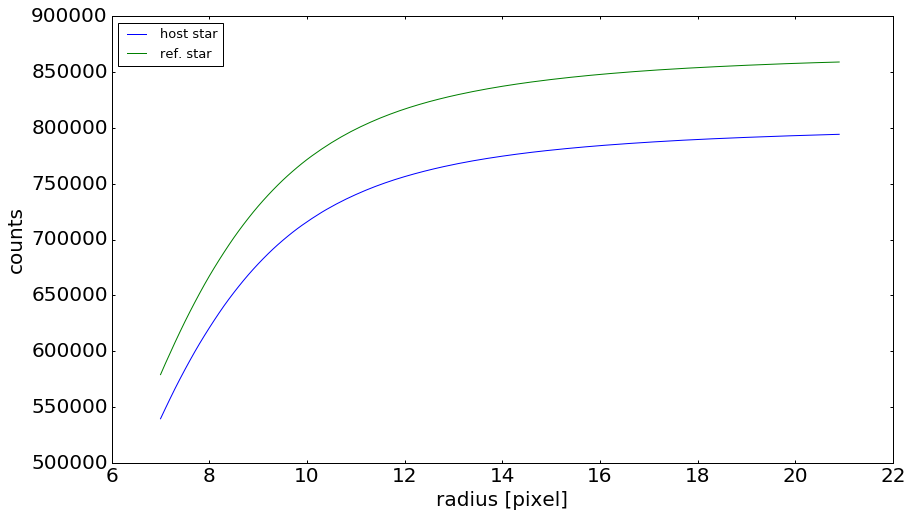

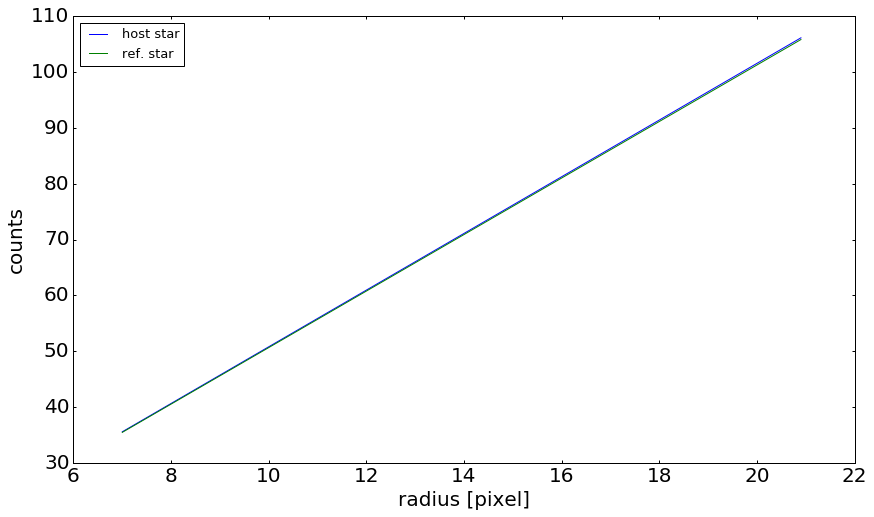

In [248]:
plt.figure()
plt.plot(flux_data.radius,flux_data.hoststar,label='host star')#/flux_data.refstar)
plt.plot(flux_data.radius,flux_data.refstar,label='ref. star')
plt.xlabel('radius [pixel]')
plt.ylabel('Flux [counts]')
plt.legend()

plt.figure()
plt.plot(flux_data.radius,flux_data.hoststar_err,label='host star')#/flux_data.refstar)
plt.plot(flux_data.radius,flux_data.refstar_err,label='ref. star')
plt.xlabel('radius [pixel]')
plt.ylabel('Ercounts')
plt.legend()